In [1]:
import torch
import torchvision
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import accuracy_score
import cv2

In [2]:
SEED = 1

# Use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Current Device:', device)

cpu


In [3]:
imagenette_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ]
)

In [4]:
data_train = torchvision.datasets.Imagenette(root='./datasets/imagenette', split='train', download=False, transform=imagenette_transforms)
data_val = torchvision.datasets.Imagenette(root='./datasets/imagenette', split='val', download=False, transform=imagenette_transforms)

In [5]:
class ImagenetteDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        self.transforms = transform
        self.data = data

    def __getitem__(self,index):
        image,label = self.data[index]
        if self.transforms != None:
            image = self.transforms(image)

        label = 1 if label==3 else 0

        return image,label

    def __len__(self):
        return len(self.data)

In [6]:
data_train_chainsaw = ImagenetteDataset(data_train)
data_val_chainsaw = ImagenetteDataset(data_val)

In [7]:
train_loader = torch.utils.data.DataLoader(data_train_chainsaw, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val_chainsaw, batch_size=64, shuffle=False)

In [8]:
model = models.resnet18()
lr = 0.008
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
def train(model, data_loader, criterion, optimizer):
    model.train()
    model.to(device)

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for inputs, targets in train_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
    average_train_loss = running_loss / running_steps
    accuracy = n_correct / n_total * 100.

    return average_train_loss, accuracy

In [10]:
@torch.no_grad()
def test(model, data_loader, criterion, optimizer):
    model.eval()
    model.to(device)

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for inputs, targets in test_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
    average_test_loss = running_loss / running_steps
    accuracy = n_correct / n_total * 100.0

    return average_test_loss, accuracy

In [11]:
for i in range(2):
    train_avg_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    if (i+1)%10 == 0:
        val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
        print('Epoch: {:3d}, Train Average Loss: {:.2f}, Train Accuracy: {:.1f}%, Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
              .format(i+1, train_avg_loss, train_accuracy, val_avg_loss, val_accuracy))

   train:   0%|          | 0/148 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
print('Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
              .format(val_avg_loss, val_accuracy))

   test: 100%|██████████| 62/62 [00:23<00:00,  2.59it/s]

Validation Average Loss: 0.36, Validation Accuracy: 90.2%


In [ ]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

model._modules.get('layer4').register_forward_hook(hook_feature)

params = list(model.parameters())
weight = np.squeeze(params[-2].data.cpu().numpy())
print(params[-2].shape)
print(weight.shape)

torch.Size([1000, 512])
(1000, 512)


In [ ]:
def cam(im):
    # Displays CAM for a tensor-image im (shape (3,im_height,im_width))
    sample_img = torch.autograd.Variable(data_val_chainsaw[50][0].unsqueeze(0))
    sample_img = sample_img.to(device)
    model.to(device)
    logit = model(sample_img)

    _, nc, h, w = features_blobs[0].shape
    r = np.reshape(features_blobs[0], (nc, h*w))
    r.shape

    c = weight[0] @ r
    c = c.reshape((h, w))
    c = c - np.min(c)
    c = c / np.max(c)
    c_i = np.uint8(255 * c)
    c_i = cv2.resize(c_i, (224, 224))

    img = np.uint8(255 * data_val_chainsaw[50][0].permute(1, 2, 0).numpy())
    heatmap = cv2.applyColorMap(c_i, cv2.COLORMAP_JET)
    result = np.uint8(0.3 * heatmap + 0.5 * img)
    plt.imshow(result)
    plt.show()

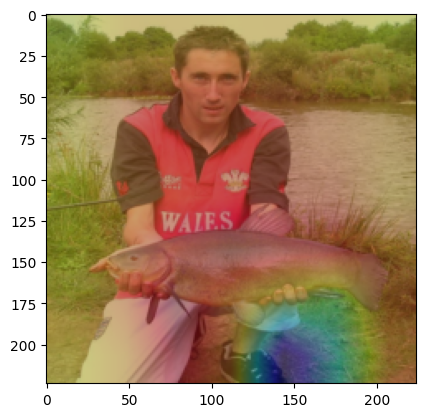

In [ ]:
cam(data_val_chainsaw[50][0])